1. Get data from Kaggle
2. Read Official list of data from my Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files

files.upload()  # this will prompt you to upload the kaggle.json :)

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"springinwinter","key":"a2604ce869103163aa506ae63a9c7b4b"}'}

In [ ]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d nih-chest-xrays/data

100% 42.0G/42.0G [36:41<00:00, 23.5MB/s]
100% 42.0G/42.0G [36:41<00:00, 20.5MB/s]


In [ ]:
!unzip /content/data.zip

Install libraries && Import


In [ ]:
!pip install torchmetrics

In [ ]:
import gc
import numpy as np
import pandas as pd
import os
import torch
from torch import tensor
from torch.utils.data import Dataset
import pandas as pd
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import swin_t

from tqdm import tqdm
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from torch import tensor
from torchmetrics.classification import MulticlassAUROC,AUROC

from PIL import Image
import random
import copy
import csv

In [ ]:
!pip install torchvision

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = swin_t()
#model = swin_t(weights='DEFAULT') # weights='IMAGENET1K_V1'
#model.head = torch.nn.Linear(out_features=14,in_features=768)

from torchvision.models import swin_b as SwinTransformer
model = SwinTransformer(weights='DEFAULT')
model.head = torch.nn.Linear(out_features=14,in_features=1024)

Downloading: "https://download.pytorch.org/models/swin_b-68c6b09e.pth" to /root/.cache/torch/hub/checkpoints/swin_b-68c6b09e.pth
100%|██████████| 335M/335M [00:37<00:00, 9.27MB/s]


In [ ]:
model.head

Linear(in_features=1024, out_features=1000, bias=True)

In [ ]:

#model.head= nn.Sequential(
#            nn.Linear(1024, 512, bias=True),
#            nn.ReLU(inplace=True),
#            nn.Linear(512, 14 ,bias=False)
# )
#model.head

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=512, out_features=14, bias=False)
)

In [ ]:

model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Train & Test functions

In [ ]:
def train_one_epoch(train_dataloader):

    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_dataloader):

        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    return np.mean(running_loss)

def val_one_epoch(val_dataloader):

    model.eval()
    running_loss = 0.0

    for images, labels in tqdm(test_dataloader):

        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

    return np.mean(running_loss) ;


Read data:

In [ ]:
from torchvision.utils import save_image

class ChestXray14Dataset(Dataset):

  def __init__(self, images_path, file_path, num_class=14,transform=None, augment = None):

    self.img_list = []
    self.img_label = []
    self.augment = augment
    self.transform =transform

    with open(file_path, "r") as fileDescriptor:
      line = True

      while line:
        line = fileDescriptor.readline()

        if line:
          lineItems = line.split()

          imageLabel = lineItems[1:num_class + 1]
          imageLabel = [int(i) for i in imageLabel]

          for i in range (1,2):
            imagePath = os.path.join(images_path,f'images_00{i}/images/',lineItems[0])

            if os.path.isfile(imagePath):

              self.img_list.append(imagePath)
              self.img_label.append(imageLabel)

              if self.augment != None:

                imageData = Image.open(imagePath).convert('RGB')
                imageData = self.augment(imageData)

                #imagePath_transfered = os.path.join(images_path,f'images_00{i}/images_transfered/')
                #if not(os.path.isdir(imagePath_transfered)):
                #    os.mkdir(imagePath_transfered)

                imagePath_transfered= os.path.join(images_path,f'images_00{i}/images/','t_' + lineItems[0])
                save_image(imageData,imagePath_transfered)

                self.img_list.append(imagePath_transfered)
                self.img_label.append(imageLabel)

  def __getitem__(self, index):

    imagePath = self.img_list[index]
    imageData = Image.open(imagePath).convert('RGB')

    if self.transform != None: imageData = self.transform(imageData)

    imageLabel = torch.FloatTensor(self.img_label[index])

    return imageData, imageLabel

  def __len__(self):

    return len(self.img_list)


In [ ]:
data_dir = '/content/drive/MyDrive'
data_dir =  '/content'

train_list = os.path.join(data_dir,'Xray14_train_official.txt')
test_list = os.path.join(data_dir,'Xray14_test_official.txt')
val_list = os.path.join(data_dir,'Xray14_val_official.txt')

outputs_path = "/content/drive/MyDrive/Outputs"
model_path = "/content/drive/MyDrive/Outputs/Models"


In [ ]:
torch.cuda.empty_cache()
gc.collect()

9

Read list of images and their address...

Create tarin and val and test datasets...

In [ ]:
augment_train = transforms.Compose([

     transforms.GaussianBlur(kernel_size=(11,11), sigma=(0.05, 2)),
     transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
     transforms.RandomRotation(degrees=10),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor()
    ])

transform = transforms.Compose([
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

dataset_train = ChestXray14Dataset(images_path= data_dir, file_path= train_list, transform= transform, augment= augment_train)

print('length of train_dataset :' , len(dataset_train))

length of train_dataset : 116900


In [ ]:
batch_size =32
train_dataloader = DataLoader(dataset_train, batch_size= batch_size, shuffle=True, num_workers=8)

In [ ]:


dataset_val   = ChestXray14Dataset(images_path= data_dir, file_path= val_list, transform= transform , augment=None)
dataset_test  = ChestXray14Dataset(images_path= data_dir, file_path= test_list, transform= transform, augment=None)

print('length of val_dataset :' , len(dataset_val))
print('length of test_dataset :' , len(dataset_test))

val_dataloader   = DataLoader(dataset_val, batch_size= batch_size, shuffle=False, num_workers=8)
test_dataloader  = DataLoader(dataset_test, batch_size= batch_size, shuffle=False, num_workers=8)

length of val_dataset : 8641
length of test_dataset : 17908


Train a Swin Transformer from scratch on NIH Chest X-rays

In [ ]:
num_epochs = 1;
train_losses = []; val_losses = [];

log_train_per_epoch = log_val_per_epoch = ''
#-------------------------------------------------------------------------------------

for epoch in range(num_epochs):
   with torch.no_grad():
    loss = train_one_epoch(train_dataloader)
    train_epoch_loss = loss/len(dataset_train)
    train_losses.append(train_epoch_loss)

    log_train_per_epoch = log_train_per_epoch + str(epoch+1) + '\t' + str(train_epoch_loss) +'\n'
    print('epoch {0:>2d}, avg tarain loss {1}'.format(epoch+1, train_epoch_loss))
    #-------------------------------------------------------------------------------------

    with torch.no_grad():

        loss = val_one_epoch(val_dataloader)

        val_epoch_loss = loss/len(dataset_val)
        val_losses.append(val_epoch_loss)

        log_val_per_epoch = log_val_per_epoch + str(epoch+1) + '\t'+ str(val_epoch_loss) +'\n'
        print('epoch {0:>2d}, avg val loss {1}'.format(epoch+1, val_epoch_loss))



  0%|          | 0/3654 [00:10<?, ?it/s]


RuntimeError: ignored

In [ ]:
def write_logg(log_file_path, log_file_name, log_message):

    path = os.path.join(log_file_path, log_file_name)
    file_object  = open(path, 'w+')
    file_object.write(log_message)
    file_object.close()

In [ ]:
write_logg(model_path,"myswinfromscratch_train.txt", log_train_per_epoch)
write_logg(model_path,"myswinfromscratch_val.txt", log_val_per_epoch)


In [ ]:
write_logg(model_path,"myswin_b3_pretrained_train.txt", log_train_per_epoch)
write_logg(model_path,"myswin_b3_pretrained_val.txt", log_val_per_epoch)

model_name = "pretrained_swin_b3_model"
torch.save(model.state_dict(), os.path.join(model_path,model_name))

In [ ]:
model_name = "swin_from_scratch_model"
torch.save(model.state_dict(), os.path.join(model_path,model_name))

Test Swin transformer from scratch

In [ ]:
from sklearn.metrics import roc_auc_score
def compute_AUCs(gt, pred):
    """Computes Area Under the Curve (AUC) from prediction scores.
    Args:
        gt: Pytorch tensor on GPU, shape = [n_samples, n_classes]
          true binary labels.
        pred: Pytorch tensor on GPU, shape = [n_samples, n_classes]
          can either be probability estimates of the positive class,
          confidence values, or binary decisions.
    Returns:
        List of AUROCs of all classes.
    """
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(14):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

In [ ]:
gc.collect()

0

In [ ]:

N_CLASSES = 14
CLASS_NAMES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
gt = torch.FloatTensor()
gt = gt.cuda()
pred = torch.FloatTensor()
pred = pred.cuda()

for epoch in range(num_epochs):
     print('Epoch {0} : \n'.format(epoch+1))
     for i, (inp, target) in enumerate(test_dataloader):
        target = target.cuda()
        gt = torch.cat((gt, target), 0)

        #bs, n_crops, c, h, w = inp.size()
        bs, c, h, w = inp.size()
        n_crops = 1
        with torch.no_grad():
          input_var = torch.autograd.Variable(inp.view(-1, c, h, w).cuda())
          output = model(inp.view(-1, c, h, w).cuda())
          output_mean = output.view(bs, n_crops ,-1).mean(1)

          pred = torch.cat((pred, output_mean.data.cuda()), 0)

     AUROCs = compute_AUCs(gt, pred)
     AUROC_avg = np.array(AUROCs).mean()
     print('The average AUROC is {AUROC_avg:.3f}'.format(AUROC_avg=AUROC_avg))
     for i in range(N_CLASSES):
        print('The AUROC of {} is {}'.format(CLASS_NAMES[i], AUROCs[i]))
     print('--------------------------------------------------------------------')

Epoch 1 : 

The average AUROC is 0.791
The AUROC of Atelectasis is 0.7605820430104788
The AUROC of Cardiomegaly is 0.8823016905531722
The AUROC of Effusion is 0.8082135115423965
The AUROC of Infiltration is 0.6937837922389901
The AUROC of Mass is 0.803323745759996
The AUROC of Nodule is 0.7244201693179063
The AUROC of Pneumonia is 0.6784223409384988
The AUROC of Pneumothorax is 0.8526866923381669
The AUROC of Consolidation is 0.7348462579633869
The AUROC of Edema is 0.8261954782429362
The AUROC of Emphysema is 0.8741686625643018
The AUROC of Fibrosis is 0.8042429105911745
The AUROC of Pleural_Thickening is 0.757329396664795
The AUROC of Hernia is 0.8751231801406347
--------------------------------------------------------------------
Epoch 2 : 

The average AUROC is 0.791
The AUROC of Atelectasis is 0.7605127006272681
The AUROC of Cardiomegaly is 0.8838436064090807
The AUROC of Effusion is 0.8072608037978317
The AUROC of Infiltration is 0.6944628721893327
The AUROC of Mass is 0.80550973

KeyboardInterrupt: ignored

In [ ]:
#  https://machinelearningmastery.com/use-statistical-significance-tests-interpret-machine-learning-results/

import scipy.stats as stats

# Collect data
scratch_scores= [0.641, 0.640,0.640,0.640,0.640,0.641,0.641,0.641,0.641,0.641]
pretrained_scores = [0.791,0.792,0.792,0.792,0.792,0.792,0.792,0.792,0.792,0.792]

# Perform t-test
t_statistic, p_value = stats.ttest_ind(pretrained_scores, scratch_scores)

print("Test statistic:", t_statistic)
print("p-value:", p_value)


import scipy.stats as stats


# Perform Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(pretrained_scores, scratch_scores)

print("Test statistic (U):", u_statistic)
print("p-value:", p_value)


Test statistic: 790.1384803829117
p-value: 2.5524820238309074e-42
Test statistic (U): 100.0
p-value: 6.386444750436982e-05


In [ ]:
import scipy.stats as stats
# Perform t-test
t_statistic, p_value = stats.ttest_ind(pretrained_scores, scratch_scores)

print("Test statistic:", t_statistic)
print("p-value: {:.15f}".format(float(p_value)))

Test statistic: 790.1384803829117
p-value: 0.000000000000000


In [ ]:
# Perform Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(pretrained_scores, scratch_scores)

print("Test statistic (U):", u_statistic)
print("p-value: {:.15f}".format(float(p_value)))

Test statistic (U): 100.0
p-value: 0.000063864447504


In [ ]:
import os
import sys

def write_logg(log_file_path, log_file_name, log_message):

    path = os.path.join(log_file_path, log_file_name)
    file_object  = open(path, 'w+')
    file_object.write(log_message)
    file_object.close()

def read_logg(log_file_path, log_file_name):
    path = os.path.join(log_file_path, log_file_name)
    file_object  = open(path, 'r')
    return file_object.read()

def read_one_line_logg(log_file_path, log_file_name , line_index = 0):
    path = os.path.join(log_file_path, log_file_name)
    file_object  = open(path, 'r')
    lines = file_object.readlines()
    return lines[line_index]


In [ ]:
myswinfromscratchmodel = model

<function matplotlib.pyplot.show(close=None, block=None)>

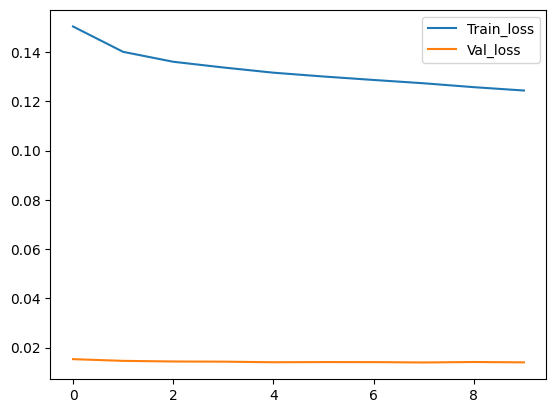

In [ ]:
plt.plot(train_losses, label='Train_loss')
plt.plot(val_losses,label='Val_loss')
plt.legend()
plt.show

In [ ]:
mypretrainedswinmodel = model

lets compaire two models by computing the p-value

In [ ]:
if p_value < 0.05:
    print(f"P-value of {p_value} give evidence that model difference is significant")
else:
    print(f"P-value of {p_value} give evidence that model difference is not significant")


P-value of 6.386444750436982e-05 give evidence that model difference is significant
